In [1]:
%matplotlib inline
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold
from matminer.featurizers.conversions import StrToComposition
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestRegressor
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
import glob

/Users/ben/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.unsupervised module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



# Collect Dataframe
* We can make some general functionality around this within Foundry itself

In [2]:
frame_files = glob.glob('./data/*/*dataframe*', recursive=True)

frames = []
for frame in frame_files:
    df_tmp = pd.read_json(frame)
    df_tmp['source'] = frame
    frames.append(df_tmp)
df = pd.concat(frames)

In [3]:
df.head()

,composition,band_gap,method,source
0,Hg0.7Cd0.3Te,0.35,experimental,./data/_test_foundry_zhuo_band_gaps_v1.1/found...
1,CuBr,3.08,experimental,./data/_test_foundry_zhuo_band_gaps_v1.1/found...
2,LuP,1.30,experimental,./data/_test_foundry_zhuo_band_gaps_v1.1/found...
3,Cu3SbSe4,0.40,experimental,./data/_test_foundry_zhuo_band_gaps_v1.1/found...
4,ZnO,3.44,experimental,./data/_test_foundry_zhuo_band_gaps_v1.1/found...


In [4]:
df.describe()

,band_gap
count,182527.000000
mean,1.443595
std,0.646368
min,0.000000
25%,1.022375
50%,1.464440
75%,1.862000
max,11.700000


# Add Composition Features

In [5]:
n_datapoints = 100
data = StrToComposition(target_col_id='composition_obj')
data = data.featurize_dataframe(df[0:n_datapoints], 
                                 'composition', 
                                 ignore_errors=True)

# Add Other Features

In [6]:
feature_calculators = MultipleFeaturizer([cf.Stoichiometry(), 
                                          cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), 
                                          cf.IonProperty(fast=True)])
feature_labels = feature_calculators.feature_labels()

data = feature_calculators.featurize_dataframe(data, 
                                               col_id='composition_obj', 
                                               ignore_errors=True);
data = data.dropna() #TODO: Look into why there are NaN's here...

# Grid Search and Fit Model

In [7]:
quick_demo=True
est = RandomForestRegressor(n_estimators=20 if quick_demo else 150, n_jobs=-1)

model = GridSearchCV(est,
                     param_grid=dict(max_features=range(8,15)),
                     scoring='neg_mean_squared_error',
                     cv=ShuffleSplit(n_splits=1,
                                     test_size=0.1))
model.fit(data[feature_labels],data['band_gap'])


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size=0.1, train_size=None),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=20, n_jobs=-1,
                                             oob_score=False, random_state=None,
                          

# Cross Validation and Scoring

In [8]:
model = model.best_estimator_
cv_prediction = cross_val_predict(model, 
                                  data[feature_labels],
                                  data['band_gap'], 
                                  cv=KFold(10, shuffle=True))

In [9]:
for scorer in ['r2_score', 'mean_absolute_error', 'mean_squared_error']:
    score = getattr(metrics,scorer)(data['band_gap'], cv_prediction)
    print(scorer, score)

r2_score 0.7094867044007055
mean_absolute_error 0.6084963333333334
mean_squared_error 0.7829896912194448


# Make Plots

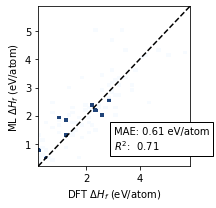

In [10]:
fig, ax = plt.subplots()

ax.hist2d(pd.to_numeric(data['band_gap']),
          cv_prediction, 
          norm=LogNorm(), 
          bins=64, 
          cmap='Blues', 
          alpha=0.9)

ax.set_xlim(ax.get_ylim())
ax.set_ylim(ax.get_xlim())

mae = metrics.mean_absolute_error(data['band_gap'], 
                                  cv_prediction)
r2 = metrics.r2_score(data['band_gap'], 
                      cv_prediction)
ax.text(0.5, 0.1, 'MAE: {:.2f} eV/atom\n$R^2$:  {:.2f}'.format(mae, r2),
        transform=ax.transAxes,
        bbox={'facecolor': 'w', 'edgecolor': 'k'})

ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.set_xlabel('DFT $\Delta H_f$ (eV/atom)')
ax.set_ylabel('ML $\Delta H_f$ (eV/atom)')

fig.set_size_inches(3, 3)
fig.tight_layout()
fig.savefig('oqmd_cv.png', dpi=320)